In [6]:
import numpy as np
from bs4 import BeautifulSoup as bs
import pandas as pd

import pandas_datareader as pdr
from pandas_datareader import data as wb
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams.update({'font.family' : 'sans'})
sm, med, lg = 10, 15, 20
plt.rc('font', size = sm)         # controls default text sizes
plt.rc('axes', titlesize = med)   # fontsize of the axes title
plt.rc('axes', labelsize = med)   # fontsize of the x & y labels
plt.rc('xtick', labelsize = sm)   # fontsize of the tick labels
plt.rc('ytick', labelsize = sm)   # fontsize of the tick labels
plt.rc('legend', fontsize = sm)   # legend fontsize
plt.rc('figure', titlesize = lg)  # fontsize of the figure title
plt.rc('axes', linewidth=2)       # linewidth of plot lines


import seaborn as sns
sns.set()

from scipy.optimize import minimize

import itertools
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor as knn
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from mpl_finance import candlestick_ohlc
from tqdm import tqdm_notebook
from pylab import rcParams


import yfinance as yf
from yahoofinancials import YahooFinancials
from urllib.request import urlopen
import requests


import locale, sys 
from datetime import date, datetime, timedelta
import time, csv, json, os, math

from IPython.display import IFrame
# ![img](images/paintcarelogo.png)

import warnings
warnings.filterwarnings('ignore')


print('\n          * * * NO ISSUES - ALL IMPORTS LOADED * * * \n')


          * * * NO ISSUES - ALL IMPORTS LOADED * * * 



# Standard Inputs:

In [7]:
start = datetime(2018, 1, 2)
end = datetime.now()

ticker = 'TSLA'
# ticker = input('Ticker: ')
tickers = [ticker, '^GSPC', '^IXIC', '^DJI']

# Finance Test:

PLOT the daily percentage change for `daily_close_px`

 Plot a scatter matrix with the `daily_pct_change` data 

 quarter.pct_change


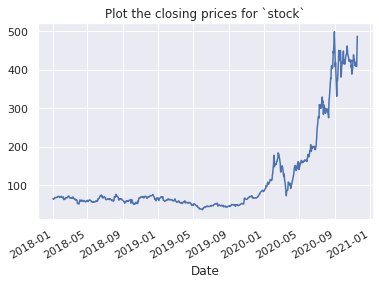

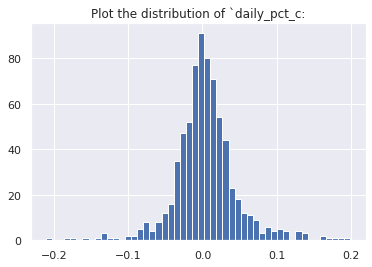

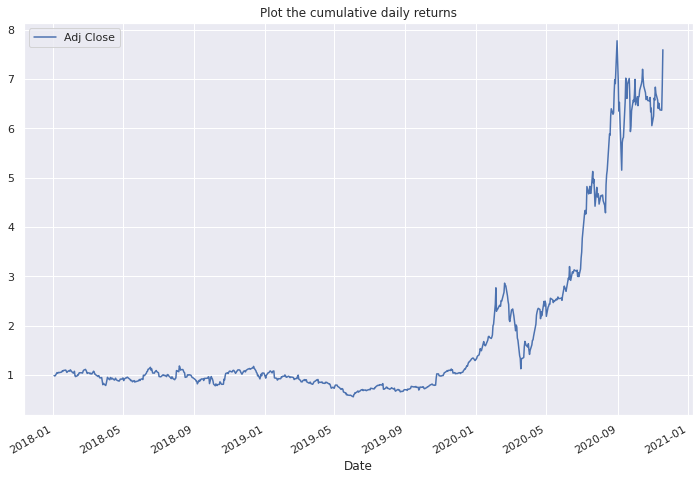

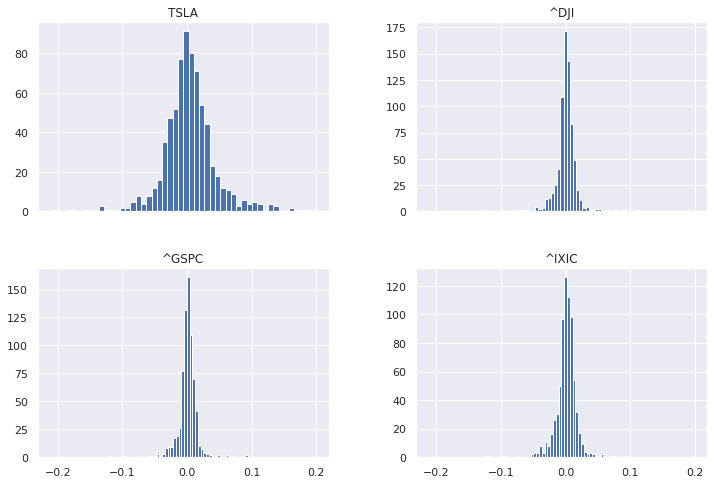

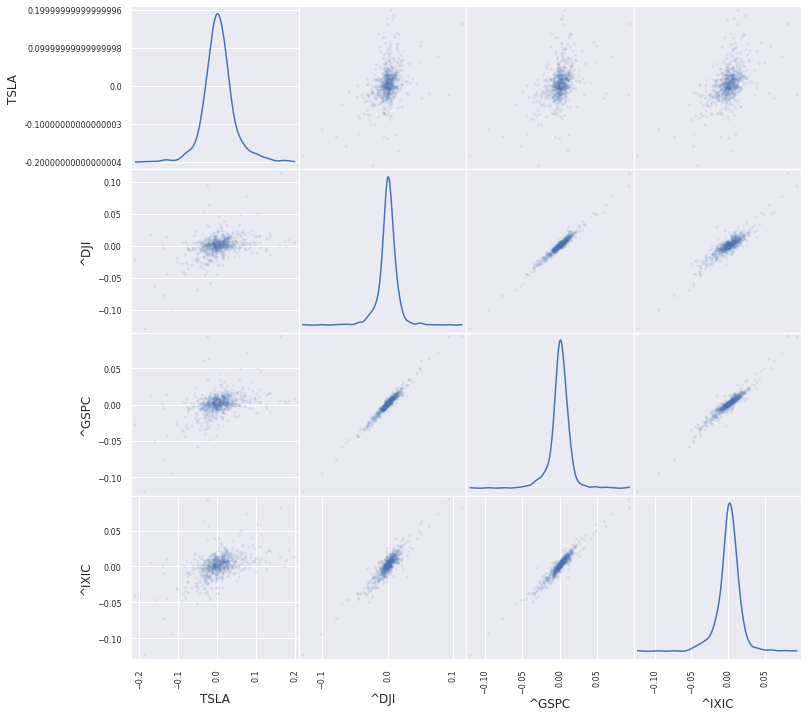

In [11]:
stock = pdr.get_data_yahoo(ticker, start=start,end=end)
# Select only the last 10 observations of `Close`
ts = stock['Close'][-10:]

# Sample 20 rows
sample = stock.sample(20)
# Resample to monthly level 
monthly_stock = stock.resample('M')

# Add a column `diff` to `stock` 
stock['diff'] = stock.Open - stock.Close
del stock['diff']

# Plot the closing prices for `stock`
stock['Close'].plot(grid=True)
plt.title('Plot the closing prices for `stock`')


daily_close = stock[['Adj Close']]
daily_pct_c = daily_close.pct_change()
daily_pct_c.fillna(0, inplace=True)
daily_log_returns = np.log(daily_close.pct_change()+1)

# Resample `stock` to business months, take last observation as value 
monthly = stock.resample('BM').apply(lambda x: x[-1])
# Calculate the monthly percentage change
monthly.pct_change()
# Resample `stock` to quarters, take the mean as value per quarter
quarter = stock.resample("4M").mean()
 
# Daily returns
daily_pct_c = (daily_close / daily_close.shift(1) - 1)

#### summary statistics ######################################################
daily_pct_c.hist(bins=50)
plt.title('Plot the distribution of `daily_pct_c:')

###### Calculate the cumulative daily returns ############################
cum_daily_return = (1 + daily_pct_c).cumprod()

# Plot the cumulative daily returns
cum_daily_return.plot(figsize=(12,8))
plt.title('Plot the cumulative daily returns')

# Resample the cumulative daily return to cumulative monthly return 
cum_monthly_return = cum_daily_return.resample("M").mean()


###### Plot a scatter matrix with the `daily_pct_change` data ###############

def get(tickers, startdate, enddate):
    def data(ticker):
        return (pdr.get_data_yahoo(ticker, start=startdate, end=enddate))
    datas = map (data, tickers)
    return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))

all_data = get(tickers, start, end)
daily_close_px = all_data[['Adj Close']].reset_index().pivot(
    'Date', 'Ticker', 'Adj Close')

print('PLOT the daily percentage change for `daily_close_px`')
daily_pct_change = daily_close_px.pct_change()
daily_pct_change.hist(bins=50, sharex=True, figsize=(12,8))

print('\n Plot a scatter matrix with the `daily_pct_change` data ')
    # Plot a scatter matrix with the `daily_pct_change` data 
pd.plotting.scatter_matrix(
    daily_pct_change, diagonal='kde', alpha=0.1,figsize=(12,12))

print('\n quarter.pct_change')

# Moving AVerage:

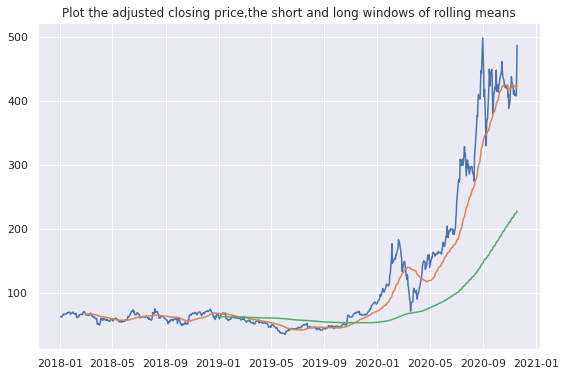

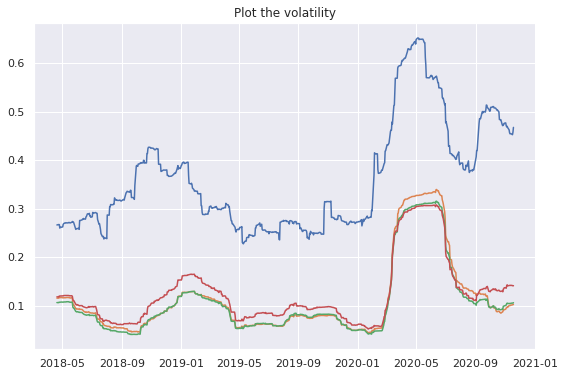

In [14]:
# Isolate the adjusted closing prices 
adj_close_px = stock['Adj Close']

# Calculate the moving average
moving_avg = adj_close_px.rolling(window=40).mean()

# windows of rolling means 
    # Short moving window rolling mean
stock['42'] = adj_close_px.rolling(window=40).mean()
    # Long moving window rolling mean
stock['252'] = adj_close_px.rolling(window=252).mean()
fig = plt.subplots(figsize = (9,6))
plt.plot(stock[['Adj Close', '42', '252']])
plt.title('Plot the adjusted closing price,\
the short and long windows of rolling means')

## Volatility Calculation - Define the minumum of periods to consider 
min_periods = 75 
# Calculate the volatility
vol = daily_pct_change.rolling(min_periods).std() * np.sqrt(min_periods) 
# Plot the volatility
fig = plt.subplots(figsize = (9,6))
plt.plot(vol)
plt.title('Plot the volatility');

# Ordinary Least-Squares Regression (OLS)

In [17]:
from pandas import tseries

    # Isolate the adjusted closing price
all_adj_close = all_data[['Adj Close']]

    # Calculate the returns 
all_returns = np.log(all_adj_close / all_adj_close.shift(1))

    # Isolate the stock returns 
stock1_returns = all_returns.iloc[
    all_returns.index.get_level_values('Ticker') == ticker]
stock1_returns.index = stock1_returns.index.droplevel('Ticker')

    # Isolate the MSFT returns
stock2_returns = all_returns.iloc[all_returns.index.get_level_values('Ticker') == tickers[1]]
stock2_returns.index = stock2_returns.index.droplevel('Ticker')

    # Build up a new DataFrame with AAPL and MSFT returns
return_data = pd.concat([stock1_returns, stock2_returns], axis=1)[1:]
return_data.columns = [ticker, tickers[1]]

    # Add a constant 
X = sm.add_constant(return_data[ticker])

    # Construct the model
model = sm.OLS(return_data[tickers[1]],X).fit()

    # Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  ^GSPC   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     182.3
Date:                Thu, 19 Nov 2020   Prob (F-statistic):           3.31e-37
Time:                        01:37:24   Log-Likelihood:                 2098.9
No. Observations:                 726   AIC:                            -4194.
Df Residuals:                     724   BIC:                            -4185.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.106e-05      0.001     -0.102      0.9

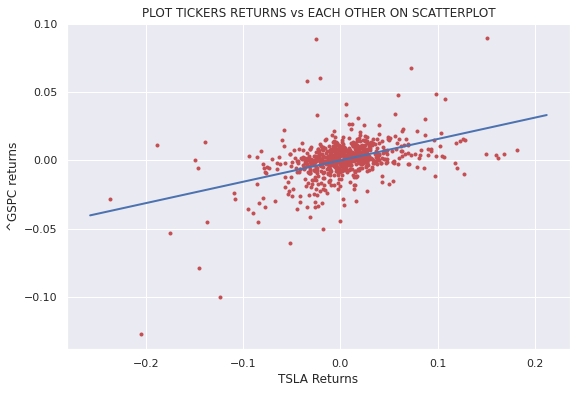

In [22]:
fig = plt.subplots(figsize = (9,6))

plt.plot(return_data[ticker], return_data[tickers[1]], 'r.')
ax = plt.axis()
x = np.linspace(ax[0], ax[1] + 0.01)
plt.plot(x, model.params[0] + model.params[1] * x, 'b', lw=2)
plt.grid(True)
plt.axis('tight')
plt.xlabel(f'{ticker} Returns')
plt.ylabel(f'{tickers[1]} returns')
plt.title('PLOT TICKERS RETURNS vs EACH OTHER ON SCATTERPLOT');

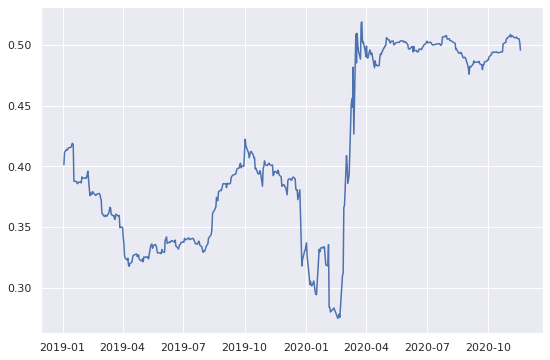

In [27]:
fig = plt.subplots(figsize = (9,6))

plt.plot(return_data[tickers[1]].rolling(window=252).corr(return_data[ticker]));

# BUILDING TRADING MODEL:

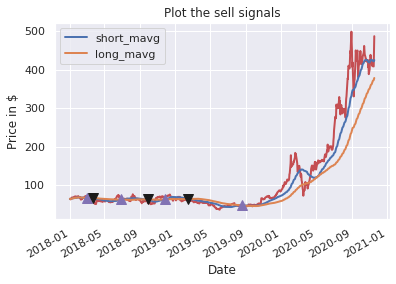

In [29]:
    # Initialize the short and long windows
short_window = 40
long_window = 100
    # Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=stock.index)
signals['signal'] = 0.0
    # Create short simple moving average over the short window
signals['short_mavg'] = stock['Close'].rolling(window=short_window,
                                              min_periods=1,
                                              center=False).mean()
    # Create long simple moving average over the long window
signals['long_mavg'] = stock['Close'].rolling(window=long_window, 
                                             min_periods=1, 
                                             center=False).mean()
    # Create signals
signals['signal'][short_window:]=np.where(signals['short_mavg'][short_window:] 
                                            >signals['long_mavg']\
                                          [short_window:],1.0, 0.0)   
    # Generate trading orders
signals['positions'] = signals['signal'].diff()

############################################################
    # Initialize the short and long windows
short_window = 40
long_window = 100
    # Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=stock.index)
signals['signal'] = 0.0
    # Create short simple moving average over the short window
signals['short_mavg'] = stock['Close'].rolling(window=short_window,
                                              min_periods=1,
                                              center=False).mean()
    # Create long simple moving average over the long window
signals['long_mavg'] = stock['Close'].rolling(window=long_window, 
                                             min_periods=1, 
                                             center=False).mean()
    # Create signals
signals['signal'][short_window:]=np.where(signals['short_mavg'][short_window:] 
                                            >signals['long_mavg']\
                                          [short_window:],1.0, 0.0)   
    # Generate trading orders
signals['positions'] = signals['signal'].diff()


############################################################
    # Initialize the plot figure
fig = plt.figure()
    # Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')
    # Plot the closing price
stock['Close'].plot(ax=ax1, color='r', lw=2.)
    # Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)
    # Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')
    # Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
ax1.set_title('Plot the sell signals')
    # Show the plot
plt.show()

#   Backtesting Strategy:

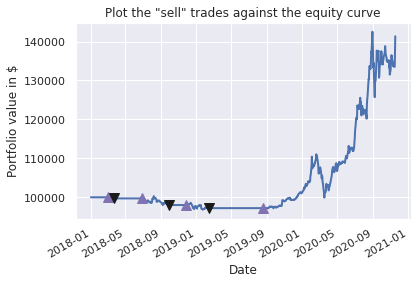

In [31]:
    # Set the initial capital
initial_capital= float(100000.0)
    # Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)
    # Buy a 100 shares
positions['AAPL'] = 100*signals['signal']   
      # Initialize the portfolio with value owned   
portfolio = positions.multiply(stock['Adj Close'], axis=0)
    # Store the difference in shares owned 
pos_diff = positions.diff()
    # Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(stock['Adj Close'], axis=0)).sum(axis=1)
    # Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(stock['Adj Close'], axis=0)).sum(axis=1).cumsum()   
    # Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    # Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()


############################################################################

import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')
    # Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)
    # Plot the "buy" trades against the equity curve
ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')
    # Plot the "sell" trades against the equity curve
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')
ax1.set_title('Plot the "sell" trades against the equity curve')
    # Show the plot
plt.show()

# Evaluating Moving Average Model:

In [33]:
# DISPLAY AS PERCENTAGE
def display_as_percentage(val):
    return ('{:.2f} %'.format(val * 100))
    
    # Isolate the returns of your strategy
returns = portfolio['returns']
    # annualized Sharpe ratio
sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())
    # Print the Sharpe ratio
    
print('SHARPE RATIO: '+display_as_percentage(sharpe_ratio))

SHARPE RATIO: 119.27 %


# Maximum Drawdown:

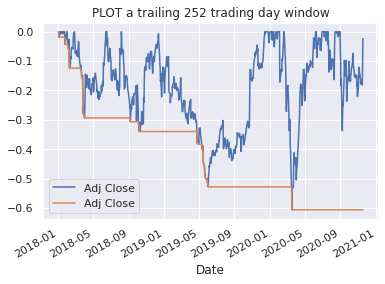

Compound Annual Growth Rate (CAGR) = 102.90 %


In [35]:
# Define a trailing 252 trading day window
window = 252
# Calculate the max drawdown in the past window days for each day
rolling_max = stock['Adj Close'].rolling(window, min_periods=1).max()
daily_drawdown = stock['Adj Close']/rolling_max - 1.0
# Calculate the minimum (negative) daily drawdown
max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()
    # Plot the results
daily_drawdown.plot()
max_daily_drawdown.plot()
plt.title('PLOT a trailing 252 trading day window')
plt.legend()

########## Compound Annual Growth Rate (CAGR) #############################
days = (stock.index[-1] - stock.index[0]).days
# Calculate the CAGR 
cagr = ((((stock['Adj Close'][-1]) / stock['Adj Close'][1])) ** (365.0/days)) - 1
# Print CAGR
print('Compound Annual Growth Rate (CAGR) = '+display_as_percentage(cagr))